In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score , KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import CVScores
from yellowbrick.regressor.alphas import alphas
from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor import ManualAlphaSelection
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from yellowbrick.datasets import load_concrete
from yellowbrick.features import PCA as YBPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from matplotlib import cm



plt.style.use('seaborn')

C:\Users\Jeriel\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
dfmain = pd.read_csv('./dataset/x.csv')

In [3]:
dfmain.columns

Index(['Ticker', 'Company', 'Sector', 'Industry', 'Country', 'Market Cap',
       'P/E', 'Forward P/E', 'PEG', 'P/S', 'P/B', 'P/Cash', 'P/Free Cash Flow',
       'Dividend Yield', 'Payout Ratio', 'EPS (ttm)', 'EPS growth this year',
       'EPS growth next year', 'EPS growth past 5 years',
       'EPS growth next 5 years', 'Sales growth past 5 years',
       'EPS growth quarter over quarter', 'Sales growth quarter over quarter',
       'Shares Outstanding', 'Shares Float', 'Insider Ownership',
       'Insider Transactions', 'Institutional Ownership',
       'Institutional Transactions', 'Float Short', 'Short Ratio',
       'Return on Assets', 'Return on Equity', 'Return on Investment',
       'Current Ratio', 'Quick Ratio', 'LT Debt/Equity', 'Total Debt/Equity',
       'Gross Margin', 'Operating Margin', 'Profit Margin', 'Beta',
       '50-Day Simple Moving Average', '200-Day Simple Moving Average',
       'Average Volume', 'Relative Volume', 'Price', '50 sma price',
       '200 sma pr

In [4]:
# compiling the list of final features
final_features = [ 'Sector', 'Industry', 'Market Cap',
       'P/E', 'Forward P/E', 'PEG', 'P/S', 'P/B', 'P/Cash', 'P/Free Cash Flow',
       'Dividend Yield', 'Payout Ratio', 'EPS (ttm)', 'EPS growth this year',
       'EPS growth next year', 'EPS growth past 5 years',
       'EPS growth next 5 years', 'Sales growth past 5 years',
       'EPS growth quarter over quarter', 'Sales growth quarter over quarter',
       'Shares Float', 'Insider Ownership',
       'Insider Transactions', 'Institutional Ownership',
       'Institutional Transactions', 'Float Short', 'Short Ratio',
       'Return on Assets', 'Return on Equity', 'Return on Investment',
        'Quick Ratio', 'LT Debt/Equity', 'Total Debt/Equity',
       'Gross Margin', 'Operating Margin', 'Profit Margin', 'Beta',       
       'Average Volume', 'Relative Volume','goldencross', 'EPS', 'Earnings Growth',
       'Sales Per Share', 'Qtr Book Value Per Share', 'dividend']

In [5]:
df = dfmain[final_features] 

In [6]:
df.shape

(4268, 45)

In [7]:
#one hot encoding for categorical features
df = pd.get_dummies(df,columns =["Sector","Industry","goldencross"])
    

In [8]:
X = df.drop(['Market Cap'],axis = 1)

In [9]:
y  = df['Market Cap']

# Train/Test Split

In [10]:
# train at 80% of data , test on 20% of data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,train_size = 0.80)


# Scaling

In [11]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

# Y-Values DataFrame & Function

In [12]:
# Making a dataframe to store Stock Ticker and its current market cap and each model predicted market cap
results = pd.DataFrame({'Ticker': dfmain['Ticker'],'Actual':y_test.values},index=X_test.index,columns=['Ticker','Actual'])

In [13]:
#function to include each model's predicted market cap value back to results dataframe
def resultsj (j,colname,ivtest):
    results[colname] = j.predict(ivtest)
    results[colname] = round(results[colname],2)
    return results

# Metrics DataFrame & Function

In [14]:
# function to call R2 Adjusted results
def r2_adj(y_test, y_preds, p):
    n = len(y_test)
    
    y_mean = np.mean(y_test)
    numerator = np.sum(np.square(y_test - y_preds)) / (n - p - 1)
    denominator = np.sum(np.square(y_test - y_mean)) / (n - 1)
    return 1 - numerator / denominator

In [15]:
# function to put each model's metric value in a dictionary, then back to master dict, metricj
metricj = dict()
def metricx(j,j2,ivtrain,ivtest):
    metric = dict()
    metric['Mean Absolute Error'] = mean_absolute_error(y_test, j.predict(ivtest),
                                                        multioutput='uniform_average')
    metric['Mean Squared Error'] = mean_squared_error(y_test,j.predict(ivtest))
    metric['Root MSE'] = np.sqrt(mean_squared_error(y_test,j.predict(ivtest)))
    metric['R2 Adjusted'] = r2_adj(y_test,j.predict(ivtest),ivtest.shape[1])
    metric['R2 Train Score'] = j.score(ivtrain,y_train)
    metric['R2 Test Score'] = j.score(ivtest,y_test)

    metricj[j2] = metric
    return pd.DataFrame(metricj)

# Coeffcients DataFrame & Function

In [16]:
#creating an empty dataframe for coefficients of each model 
coefficientsx = pd.DataFrame(index=X_train.columns)

In [17]:
# function to store each model's coefficient values
def coefx(str_model_name,model_instan):
    coefficientsx[str_model_name] = model_instan.coef_
    return coefficientsx

# Linear Regression

In [18]:
# instantiating linear regression model
lr = LinearRegression()
lr.fit(Xs_train,y_train)

LinearRegression()

In [19]:
resultsj(lr,'lrpred',Xs_test)

,Ticker,Actual,lrpred
1702,BME,494.52,1223.09
1173,NYCB,3804.13,3115.94
308,WTS,3395.62,1945.09
1322,MTLS,1940.69,1709.09
2570,NEOS,27.66,147.94
...,...,...,...
912,SGH,690.80,1417.94
443,DXLG,15.09,-112.06
1483,RNA,1084.81,1115.09
668,PAVM,86.93,51.94


In [20]:
metricx(lr,'lr',Xs_train,Xs_test)

,lr
Mean Absolute Error,556.641055
Mean Squared Error,645736.453271
R2 Adjusted,0.367885
R2 Test Score,0.518318
R2 Train Score,0.519840
Root MSE,803.577285


In [21]:
coefx('lr_cf',lr)

,lr_cf
P/E,2.627591e+01
Forward P/E,7.653420e+01
PEG,-5.806233e+00
P/S,8.299376e+00
P/B,-2.621806e+00
...,...
Industry_Utilities - Renewable,2.751560e+15
Industry_Waste Management,1.447900e+15
goldencross_buy,-9.696411e+15
goldencross_neutral,-2.287509e+15


In [22]:
from yellowbrick.regressor import PredictionError

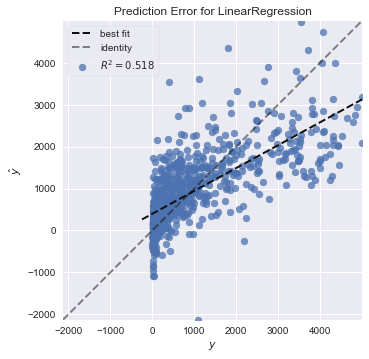

In [23]:
visualiser = PredictionError(lr)
visualiser.fit(Xs_train,y_train)
visualiser.score(Xs_test,y_test)
visualiser.show()

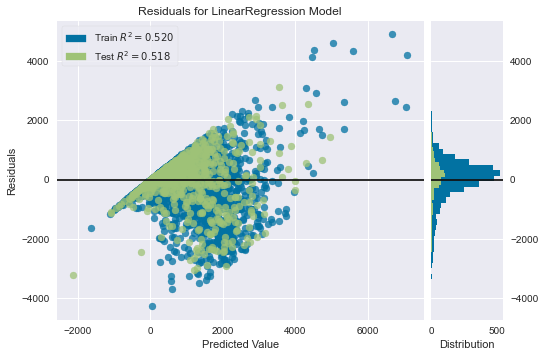

In [24]:
# visualising residual error with train/validation data
visualizer = ResidualsPlot(lr)
visualizer.fit(Xs_train, y_train)
visualizer.score(Xs_test, y_test)
visualizer.show()

# Linear Regression Regularisation 

 ### Linear Regression - Ridge / R2 
 - As alpha increases , the coefficients decays closes to 0 , but no 0 

In [25]:
# RidgeCV what it does is it finds the optimal alpha, and then fits into the model 
# alphas is being assigned to 200 generated numbers from 10^1 to 10^5  <-- logspace 0,5,200 means this
# if it is linspace 0,5, 200 it is from value 0 to 5 with 200 points
# ridge will automatically find the best alpha here 
# .alpha_ is the optimal alpha


ridge = RidgeCV(alphas=(np.logspace(0,5,200)) ,cv=10)
ridge.fit(Xs_train,y_train)



RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]),
        cv=10)

In [26]:
resultsj(ridge,'lr_ridge_pred',Xs_test)

,Ticker,Actual,lrpred,lr_ridge_pred
1702,BME,494.52,1223.09,1140.00
1173,NYCB,3804.13,3115.94,2645.69
308,WTS,3395.62,1945.09,1925.33
1322,MTLS,1940.69,1709.09,1547.72
2570,NEOS,27.66,147.94,195.02
...,...,...,...,...
912,SGH,690.80,1417.94,1387.11
443,DXLG,15.09,-112.06,279.39
1483,RNA,1084.81,1115.09,1097.31
668,PAVM,86.93,51.94,-56.71


In [27]:
metricx(ridge,'lr_ridge',Xs_train,Xs_test)

,lr,lr_ridge
Mean Absolute Error,556.641055,546.327335
Mean Squared Error,645736.453271,635356.261119
Root MSE,803.577285,797.092379
R2 Adjusted,0.367885,0.378046
R2 Train Score,0.519840,0.525920
R2 Test Score,0.518318,0.526061


In [28]:
coefx('lr_ridge_cf',ridge)

,lr_cf,lr_ridge_cf
P/E,2.627591e+01,25.327702
Forward P/E,7.653420e+01,63.095401
PEG,-5.806233e+00,-7.969645
P/S,8.299376e+00,5.253895
P/B,-2.621806e+00,-2.747203
...,...,...
Industry_Utilities - Renewable,2.751560e+15,16.598038
Industry_Waste Management,1.447900e+15,2.001962
goldencross_buy,-9.696411e+15,31.926217
goldencross_neutral,-2.287509e+15,24.200636


 ### Linear Regression - Lasso

In [29]:
# instantiating lasso cv with testing 500 alphas in a regularisation path 
lasso = LassoCV(n_alphas=500 ,cv=10,random_state=42)

lasso.fit(Xs_train,y_train)


LassoCV(cv=10, n_alphas=500, random_state=42)

In [30]:
resultsj(lasso,'lr_lasso_pred',Xs_test)

,Ticker,Actual,lrpred,lr_ridge_pred,lr_lasso_pred
1702,BME,494.52,1223.09,1140.00,1241.15
1173,NYCB,3804.13,3115.94,2645.69,3074.79
308,WTS,3395.62,1945.09,1925.33,1837.17
1322,MTLS,1940.69,1709.09,1547.72,1448.15
2570,NEOS,27.66,147.94,195.02,168.69
...,...,...,...,...,...
912,SGH,690.80,1417.94,1387.11,1228.37
443,DXLG,15.09,-112.06,279.39,380.37
1483,RNA,1084.81,1115.09,1097.31,1221.80
668,PAVM,86.93,51.94,-56.71,-47.56


In [31]:
metricx(lasso,'lr_lasso',Xs_train,Xs_test)

,lr,lr_ridge,lr_lasso
Mean Absolute Error,556.641055,546.327335,519.760771
Mean Squared Error,645736.453271,635356.261119,587375.652367
Root MSE,803.577285,797.092379,766.404366
R2 Adjusted,0.367885,0.378046,0.425015
R2 Train Score,0.519840,0.525920,0.516382
R2 Test Score,0.518318,0.526061,0.561852


In [32]:
coefx('lr_lasso_cf',lasso)

,lr_cf,lr_ridge_cf,lr_lasso_cf
P/E,2.627591e+01,25.327702,14.604229
Forward P/E,7.653420e+01,63.095401,63.420490
PEG,-5.806233e+00,-7.969645,-0.000000
P/S,8.299376e+00,5.253895,0.000000
P/B,-2.621806e+00,-2.747203,-0.000000
...,...,...,...
Industry_Utilities - Renewable,2.751560e+15,16.598038,9.233198
Industry_Waste Management,1.447900e+15,2.001962,0.000000
goldencross_buy,-9.696411e+15,31.926217,0.000000
goldencross_neutral,-2.287509e+15,24.200636,4.524902


 ### Linear Regression - ElasticNet

In [33]:
#instantiate elasticnet model , with 0.50 ratio of lasso and ridge
elastic = ElasticNetCV(cv=10,n_alphas=500,random_state=42)
elastic.fit(Xs_train,y_train)

ElasticNetCV(cv=10, n_alphas=500, random_state=42)

In [34]:
resultsj(elastic,'lr_elastic_pred',Xs_test)

,Ticker,Actual,lrpred,lr_ridge_pred,lr_lasso_pred,lr_elastic_pred
1702,BME,494.52,1223.09,1140.00,1241.15,1079.46
1173,NYCB,3804.13,3115.94,2645.69,3074.79,2257.66
308,WTS,3395.62,1945.09,1925.33,1837.17,1801.42
1322,MTLS,1940.69,1709.09,1547.72,1448.15,1478.48
2570,NEOS,27.66,147.94,195.02,168.69,349.37
...,...,...,...,...,...,...
912,SGH,690.80,1417.94,1387.11,1228.37,1357.39
443,DXLG,15.09,-112.06,279.39,380.37,383.06
1483,RNA,1084.81,1115.09,1097.31,1221.80,1047.68
668,PAVM,86.93,51.94,-56.71,-47.56,5.02


In [35]:
metricx(elastic,'lr_elastic',Xs_train,Xs_test)

,lr,lr_ridge,lr_lasso,lr_elastic
Mean Absolute Error,556.641055,546.327335,519.760771,566.762180
Mean Squared Error,645736.453271,635356.261119,587375.652367,673575.327393
Root MSE,803.577285,797.092379,766.404366,820.716350
R2 Adjusted,0.367885,0.378046,0.425015,0.340633
R2 Train Score,0.519840,0.525920,0.516382,0.497860
R2 Test Score,0.518318,0.526061,0.561852,0.497552


In [36]:
coefx('lr_elastic_cf',elastic)

,lr_cf,lr_ridge_cf,lr_lasso_cf,lr_elastic_cf
P/E,2.627591e+01,25.327702,14.604229,21.239412
Forward P/E,7.653420e+01,63.095401,63.420490,54.720372
PEG,-5.806233e+00,-7.969645,-0.000000,-5.555167
P/S,8.299376e+00,5.253895,0.000000,3.938746
P/B,-2.621806e+00,-2.747203,-0.000000,-1.845695
...,...,...,...,...
Industry_Utilities - Renewable,2.751560e+15,16.598038,9.233198,14.329563
Industry_Waste Management,1.447900e+15,2.001962,0.000000,1.281315
goldencross_buy,-9.696411e+15,31.926217,0.000000,28.644739
goldencross_neutral,-2.287509e+15,24.200636,4.524902,17.010119


# PCA with Linear Regression
- no coefficients as they are super features

In [37]:
# gridsearhc across 60, 70 and 80 of superfeatures to take and then fit on Xs_train
pipe = Pipeline([ 
                ('pca',PCA(random_state = 42))
])


params = {
    'pca__n_components' : [60,70,80],
    'pca__svd_solver' : ['auto' , 'full' ]
                         
}


grid = GridSearchCV(estimator = pipe, param_grid = params, cv =10)

grid.fit(Xs_train)

print(grid.best_params_)


{'pca__n_components': 60, 'pca__svd_solver': 'auto'}


In [38]:
# after fitting , transform the features to superfeatures on Xs_train and Xs_test
Z_train = grid.transform (Xs_train)
Z_test = grid.transform(Xs_test)

lr.fit(Z_train,y_train)

LinearRegression()

In [39]:
resultsj(lr,'lr_PCA_pred',Z_test)

,Ticker,Actual,lrpred,lr_ridge_pred,lr_lasso_pred,lr_elastic_pred,lr_PCA_pred
1702,BME,494.52,1223.09,1140.00,1241.15,1079.46,996.93
1173,NYCB,3804.13,3115.94,2645.69,3074.79,2257.66,1731.29
308,WTS,3395.62,1945.09,1925.33,1837.17,1801.42,1977.53
1322,MTLS,1940.69,1709.09,1547.72,1448.15,1478.48,1695.81
2570,NEOS,27.66,147.94,195.02,168.69,349.37,896.65
...,...,...,...,...,...,...,...
912,SGH,690.80,1417.94,1387.11,1228.37,1357.39,1448.36
443,DXLG,15.09,-112.06,279.39,380.37,383.06,311.51
1483,RNA,1084.81,1115.09,1097.31,1221.80,1047.68,920.46
668,PAVM,86.93,51.94,-56.71,-47.56,5.02,-170.77


In [40]:
metricx(lr,'PCA',Z_train,Z_test)

,lr,lr_ridge,lr_lasso,lr_elastic,PCA
Mean Absolute Error,556.641055,546.327335,519.760771,566.762180,628.296429
Mean Squared Error,645736.453271,635356.261119,587375.652367,673575.327393,841248.856139
Root MSE,803.577285,797.092379,766.404366,820.716350,917.196193
R2 Adjusted,0.367885,0.378046,0.425015,0.340633,0.324997
R2 Train Score,0.519840,0.525920,0.516382,0.497860,0.402952
R2 Test Score,0.518318,0.526061,0.561852,0.497552,0.372477


# Random Forrest / Decision Tree  --- NO SCALING ---

- unable to tell coefficients 

In [41]:
# Building GridSearch pipe for decision tree strcture
pipe = Pipeline([ 
                ('dt',DecisionTreeRegressor(random_state = 42))
])


params = {
    'dt__max_depth':[2,3,5,7],
    'dt__min_samples_split': [5, 10, 15, 20],
    'dt__min_samples_leaf': [2, 3, 4, 5, 6],
    'dt__ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10]
}


grid = GridSearchCV(estimator = pipe, param_grid = params, cv =5)

grid.fit(X_train,y_train )

print(grid.best_params_)


{'dt__ccp_alpha': 0, 'dt__max_depth': 7, 'dt__min_samples_leaf': 5, 'dt__min_samples_split': 20}


In [42]:
resultsj(grid,'rf_pred',X_test)

,Ticker,Actual,lrpred,lr_ridge_pred,lr_lasso_pred,lr_elastic_pred,lr_PCA_pred,rf_pred
1702,BME,494.52,1223.09,1140.00,1241.15,1079.46,996.93,1479.32
1173,NYCB,3804.13,3115.94,2645.69,3074.79,2257.66,1731.29,2864.12
308,WTS,3395.62,1945.09,1925.33,1837.17,1801.42,1977.53,2720.14
1322,MTLS,1940.69,1709.09,1547.72,1448.15,1478.48,1695.81,862.32
2570,NEOS,27.66,147.94,195.02,168.69,349.37,896.65,129.45
...,...,...,...,...,...,...,...,...
912,SGH,690.80,1417.94,1387.11,1228.37,1357.39,1448.36,595.06
443,DXLG,15.09,-112.06,279.39,380.37,383.06,311.51,129.45
1483,RNA,1084.81,1115.09,1097.31,1221.80,1047.68,920.46,1242.11
668,PAVM,86.93,51.94,-56.71,-47.56,5.02,-170.77,129.45


In [43]:
metricx(grid,'rf',X_train,X_test)

,lr,lr_ridge,lr_lasso,lr_elastic,PCA,rf
Mean Absolute Error,556.641055,546.327335,519.760771,566.762180,628.296429,380.335163
Mean Squared Error,645736.453271,635356.261119,587375.652367,673575.327393,841248.856139,433248.437532
Root MSE,803.577285,797.092379,766.404366,820.716350,917.196193,658.216102
R2 Adjusted,0.367885,0.378046,0.425015,0.340633,0.324997,0.575891
R2 Train Score,0.519840,0.525920,0.516382,0.497860,0.402952,0.817572
R2 Test Score,0.518318,0.526061,0.561852,0.497552,0.372477,0.676822


# Deep Learning - Neural Networks 
- running at 3 hidden layers
- fixed parameters that were previously hyper-tune for faster reloading
- unable to use metricsx and coefficients function

In [44]:
# 3 hidden layers model
def model_func(layer_one_neurons, layer_two_neurons,layer_three_neurons):
    model = Sequential()
    
    model.add(Dense(layer_one_neurons, activation='relu', input_shape=(Xs_train.shape[1],)))
    
    model.add(Dense(layer_two_neurons, 
                    activation='relu'))
    
    model.add(Dense(layer_three_neurons, 
                    activation='relu'))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam',metrics=[RootMeanSquaredError()])
    
    return model


In [45]:
# Model Instantiation
nn = KerasRegressor(build_fn=model_func, batch_size=512, verbose=0)

# Params
params = {
    'epochs': [500],
    'layer_one_neurons': [300],
    'layer_two_neurons': [200],
    'layer_three_neurons': [100]
}
# Grid Searching
gs = GridSearchCV(nn, param_grid=params, cv=10)
gs.fit(Xs_train, y_train,validation_data=(Xs_test, y_test),batch_size=512)

# Have to type out the history assignment 1 more time with best estimator\
#because if not the gs will take all the grid searched parameters models history



print(gs.best_score_)
print(gs.best_params_)

-5789223.365625
{'epochs': 500, 'layer_one_neurons': 300, 'layer_three_neurons': 100, 'layer_two_neurons': 200}


In [46]:
history = gs.best_estimator_.fit(Xs_train, y_train,validation_data=(Xs_test, y_test),batch_size=512)

train_loss = history.history['root_mean_squared_error']
test_loss = history.history['val_root_mean_squared_error']

In [47]:
resultsj(grid,'dl_pred',Xs_test)

,Ticker,Actual,lrpred,lr_ridge_pred,lr_lasso_pred,lr_elastic_pred,lr_PCA_pred,rf_pred,dl_pred
1702,BME,494.52,1223.09,1140.00,1241.15,1079.46,996.93,1479.32,155.73
1173,NYCB,3804.13,3115.94,2645.69,3074.79,2257.66,1731.29,2864.12,31.73
308,WTS,3395.62,1945.09,1925.33,1837.17,1801.42,1977.53,2720.14,1284.18
1322,MTLS,1940.69,1709.09,1547.72,1448.15,1478.48,1695.81,862.32,301.98
2570,NEOS,27.66,147.94,195.02,168.69,349.37,896.65,129.45,1284.18
...,...,...,...,...,...,...,...,...,...
912,SGH,690.80,1417.94,1387.11,1228.37,1357.39,1448.36,595.06,1284.18
443,DXLG,15.09,-112.06,279.39,380.37,383.06,311.51,129.45,1284.18
1483,RNA,1084.81,1115.09,1097.31,1221.80,1047.68,920.46,1242.11,1284.18
668,PAVM,86.93,51.94,-56.71,-47.56,5.02,-170.77,129.45,1284.18


## Deep Learning - Neural Networks with Regularization 
- Early Stoppage
- Dropout 
- L2 Regularization

## Regularization - Deep Learning - L2 / Ridge Regression

Alpha used here is 0.01 


In [48]:
def model_func(layer_one_neurons, layer_two_neurons,layer_three_neurons,alpha):
    model = Sequential()
    
    model.add(Dense(layer_one_neurons, activation='relu',
                    kernel_regularizer = regularizers.l2(alpha),
                    input_shape=(Xs_train.shape[1],)))
    
    model.add(Dense(layer_two_neurons, 
                    activation='relu',
                   kernel_regularizer = regularizers.l2(alpha)))
    
    model.add(Dense(layer_three_neurons, 
                    activation='relu',
                   kernel_regularizer = regularizers.l2(alpha)))
    
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam',metrics=[RootMeanSquaredError()])
    
    return model


In [49]:
# Model Instantiation
nn = KerasRegressor(build_fn=model_func, batch_size=512, verbose=0)

# Params
params = {
    'epochs': [500],
    'layer_one_neurons': [300],
    'layer_two_neurons': [200],
    'layer_three_neurons': [100],
    'alpha':[0.10]
}
# Grid Searching
gs = GridSearchCV(nn, param_grid=params, cv=10)
gs.fit(Xs_train, y_train,validation_data=(Xs_test, y_test),batch_size=512)
print(gs.best_score_)
print(gs.best_params_)

-3866728.9375
{'alpha': 0.1, 'epochs': 500, 'layer_one_neurons': 300, 'layer_three_neurons': 100, 'layer_two_neurons': 200}


In [50]:
history_l2 = gs.best_estimator_.fit(Xs_train, y_train,validation_data=(Xs_test, y_test),batch_size=512)
train_loss_l2 = history_l2.history['root_mean_squared_error']
test_loss_l2 = history_l2.history['val_root_mean_squared_error']

In [51]:
resultsj(gs,'dl_ridge_pred',Xs_test)

,Ticker,Actual,lrpred,lr_ridge_pred,lr_lasso_pred,lr_elastic_pred,lr_PCA_pred,rf_pred,dl_pred,dl_ridge_pred
1702,BME,494.52,1223.09,1140.00,1241.15,1079.46,996.93,1479.32,155.73,1124.329956
1173,NYCB,3804.13,3115.94,2645.69,3074.79,2257.66,1731.29,2864.12,31.73,2810.159912
308,WTS,3395.62,1945.09,1925.33,1837.17,1801.42,1977.53,2720.14,1284.18,2506.340088
1322,MTLS,1940.69,1709.09,1547.72,1448.15,1478.48,1695.81,862.32,301.98,759.030029
2570,NEOS,27.66,147.94,195.02,168.69,349.37,896.65,129.45,1284.18,268.420013
...,...,...,...,...,...,...,...,...,...,...
912,SGH,690.80,1417.94,1387.11,1228.37,1357.39,1448.36,595.06,1284.18,764.460022
443,DXLG,15.09,-112.06,279.39,380.37,383.06,311.51,129.45,1284.18,10.810000
1483,RNA,1084.81,1115.09,1097.31,1221.80,1047.68,920.46,1242.11,1284.18,1146.439941
668,PAVM,86.93,51.94,-56.71,-47.56,5.02,-170.77,129.45,1284.18,-0.270000


## Regularization - Deep Learning - Dropout Regularization


In [52]:
def model_func(layer_one_neurons, layer_two_neurons,layer_three_neurons,proba):
    model = Sequential()
    
    model.add(Dense(layer_one_neurons, activation='relu',
                    input_shape=(Xs_train.shape[1],)))
    
    model.add(Dropout(proba))
    
    model.add(Dense(layer_two_neurons, 
                    activation='relu'))
    
    model.add(Dropout(proba))
    
    model.add(Dense(layer_three_neurons, 
                activation='relu'))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam',metrics=[RootMeanSquaredError()])
    
    return model


In [53]:
# Model Instantiation
nn = KerasRegressor(build_fn=model_func, batch_size=512, verbose=0)

# Params
params = {
    'epochs': [500],
    'layer_one_neurons': [300],
    'layer_two_neurons': [200],
    'layer_three_neurons': [100],
    'proba':[0.88]
}
# Grid Searching
gs = GridSearchCV(nn, param_grid=params, cv=10)
gs.fit(Xs_train, y_train,validation_data=(Xs_test, y_test),batch_size=512)
print(gs.best_score_)
print(gs.best_params_)

-2655926.925
{'epochs': 500, 'layer_one_neurons': 300, 'layer_three_neurons': 100, 'layer_two_neurons': 200, 'proba': 0.88}


In [54]:
history_dropout = gs.best_estimator_.fit(Xs_train, y_train,validation_data=(Xs_test, y_test),batch_size=512)
train_loss_dropout = history_dropout.history['root_mean_squared_error']
test_loss_dropout = history_dropout.history['val_root_mean_squared_error']

In [55]:
resultsj(gs,'dl_dropout_pred',Xs_test)

,Ticker,Actual,lrpred,lr_ridge_pred,lr_lasso_pred,lr_elastic_pred,lr_PCA_pred,rf_pred,dl_pred,dl_ridge_pred,dl_dropout_pred
1702,BME,494.52,1223.09,1140.00,1241.15,1079.46,996.93,1479.32,155.73,1124.329956,1109.609985
1173,NYCB,3804.13,3115.94,2645.69,3074.79,2257.66,1731.29,2864.12,31.73,2810.159912,3659.669922
308,WTS,3395.62,1945.09,1925.33,1837.17,1801.42,1977.53,2720.14,1284.18,2506.340088,2197.040039
1322,MTLS,1940.69,1709.09,1547.72,1448.15,1478.48,1695.81,862.32,301.98,759.030029,1283.589966
2570,NEOS,27.66,147.94,195.02,168.69,349.37,896.65,129.45,1284.18,268.420013,124.000000
...,...,...,...,...,...,...,...,...,...,...,...
912,SGH,690.80,1417.94,1387.11,1228.37,1357.39,1448.36,595.06,1284.18,764.460022,1085.699951
443,DXLG,15.09,-112.06,279.39,380.37,383.06,311.51,129.45,1284.18,10.810000,175.720001
1483,RNA,1084.81,1115.09,1097.31,1221.80,1047.68,920.46,1242.11,1284.18,1146.439941,753.409973
668,PAVM,86.93,51.94,-56.71,-47.56,5.02,-170.77,129.45,1284.18,-0.270000,77.059998


## Regularization - Deep Learning - Early Stopping

In [56]:
def model_func(layer_one_neurons, layer_two_neurons,layer_three_neurons,self_defined_number):
    model = Sequential()
    
    model.add(Dense(layer_one_neurons, activation='relu',
                    input_shape=(Xs_train.shape[1],)))
    
    
    model.add(Dense(layer_two_neurons, 
                    activation='relu'))
    
    model.add(Dense(layer_three_neurons, 
            activation='relu'))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam',metrics=[RootMeanSquaredError()])
    
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=self_defined_number, verbose=1, mode='auto')

    
    return model


In [57]:
# Model Instantiation
nn = KerasRegressor(build_fn=model_func, batch_size=512, verbose=0)

# Params
params = {
    'epochs': [500],
    'layer_one_neurons': [300],
    'layer_two_neurons': [200],
    'layer_three_neurons': [100],
    'self_defined_number':[5]
}
# Grid Searching
gs = GridSearchCV(nn, param_grid=params, cv=10)
gs.fit(Xs_train, y_train,validation_data=(Xs_test, y_test),batch_size=512)
print(gs.best_score_)
print(gs.best_params_)

-5770741.475
{'epochs': 500, 'layer_one_neurons': 300, 'layer_three_neurons': 100, 'layer_two_neurons': 200, 'self_defined_number': 5}


In [58]:
history_es = gs.best_estimator_.fit(Xs_train, y_train,validation_data=(Xs_test, y_test),batch_size=512)
train_loss_es = history_es.history['root_mean_squared_error']
test_loss_es = history_es.history['val_root_mean_squared_error']

In [59]:
resultsj(gs,'dl_earlystop_pred',Xs_test)

,Ticker,Actual,lrpred,lr_ridge_pred,lr_lasso_pred,lr_elastic_pred,lr_PCA_pred,rf_pred,dl_pred,dl_ridge_pred,dl_dropout_pred,dl_earlystop_pred
1702,BME,494.52,1223.09,1140.00,1241.15,1079.46,996.93,1479.32,155.73,1124.329956,1109.609985,896.630005
1173,NYCB,3804.13,3115.94,2645.69,3074.79,2257.66,1731.29,2864.12,31.73,2810.159912,3659.669922,2879.909912
308,WTS,3395.62,1945.09,1925.33,1837.17,1801.42,1977.53,2720.14,1284.18,2506.340088,2197.040039,2221.070068
1322,MTLS,1940.69,1709.09,1547.72,1448.15,1478.48,1695.81,862.32,301.98,759.030029,1283.589966,840.419983
2570,NEOS,27.66,147.94,195.02,168.69,349.37,896.65,129.45,1284.18,268.420013,124.000000,66.709999
...,...,...,...,...,...,...,...,...,...,...,...,...
912,SGH,690.80,1417.94,1387.11,1228.37,1357.39,1448.36,595.06,1284.18,764.460022,1085.699951,617.179993
443,DXLG,15.09,-112.06,279.39,380.37,383.06,311.51,129.45,1284.18,10.810000,175.720001,39.410000
1483,RNA,1084.81,1115.09,1097.31,1221.80,1047.68,920.46,1242.11,1284.18,1146.439941,753.409973,1087.209961
668,PAVM,86.93,51.94,-56.71,-47.56,5.02,-170.77,129.45,1284.18,-0.270000,77.059998,36.799999


## Regularization - Deep Learning - 3x 
- 3 hidden layers
- regularize 3 methods
    - Dropout in between layers
    - R2 regularization at each layer
    - early stoppage

In [60]:
def model_func(layer_one_neurons, layer_two_neurons,layer_three_neurons,alpha,proba,self_defined_number):
    model = Sequential()
    
    model.add(Dense(layer_one_neurons, activation='relu',
                    kernel_regularizer = regularizers.l2(alpha),
                    input_shape=(Xs_train.shape[1],)))
    
    model.add(Dropout(proba))
    
    model.add(Dense(layer_two_neurons, 
                    activation='relu',
                   kernel_regularizer = regularizers.l2(alpha)))
    
    model.add(Dropout(proba))
    
    model.add(Dense(layer_three_neurons, 
                activation='relu',
               kernel_regularizer = regularizers.l2(alpha)))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam',metrics=[RootMeanSquaredError()])
    
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=self_defined_number, verbose=1, mode='auto')

    
    return model


In [61]:
# Model Instantiation
nn = KerasRegressor(build_fn=model_func, batch_size=512, verbose=0)

# Params
params = {
    'epochs': [500],
    'layer_one_neurons': [300],
    'layer_two_neurons': [200],
    'layer_three_neurons': [100],
    'self_defined_number':[5],
    'alpha':[0.01],
    'proba':[0.88]
}
# Grid Searching
gs = GridSearchCV(nn, param_grid=params, cv=10)
gs.fit(Xs_train, y_train,validation_data=(Xs_test, y_test),batch_size=512)
print(gs.best_score_)
print(gs.best_params_)

-2648290.03125
{'alpha': 0.01, 'epochs': 500, 'layer_one_neurons': 300, 'layer_three_neurons': 100, 'layer_two_neurons': 200, 'proba': 0.88, 'self_defined_number': 5}


In [62]:
history_maxreg = gs.best_estimator_.fit(Xs_train, y_train,validation_data=(Xs_test, y_test),batch_size=512)
train_loss_maxreg = history_maxreg.history['root_mean_squared_error']
test_loss_maxreg = history_maxreg.history['val_root_mean_squared_error']

In [63]:
resultsj(gs,'dl_maxreg_pred',Xs_test)

,Ticker,Actual,lrpred,lr_ridge_pred,lr_lasso_pred,lr_elastic_pred,lr_PCA_pred,rf_pred,dl_pred,dl_ridge_pred,dl_dropout_pred,dl_earlystop_pred,dl_maxreg_pred
1702,BME,494.52,1223.09,1140.00,1241.15,1079.46,996.93,1479.32,155.73,1124.329956,1109.609985,896.630005,1258.349976
1173,NYCB,3804.13,3115.94,2645.69,3074.79,2257.66,1731.29,2864.12,31.73,2810.159912,3659.669922,2879.909912,3845.879883
308,WTS,3395.62,1945.09,1925.33,1837.17,1801.42,1977.53,2720.14,1284.18,2506.340088,2197.040039,2221.070068,2332.729980
1322,MTLS,1940.69,1709.09,1547.72,1448.15,1478.48,1695.81,862.32,301.98,759.030029,1283.589966,840.419983,1378.989990
2570,NEOS,27.66,147.94,195.02,168.69,349.37,896.65,129.45,1284.18,268.420013,124.000000,66.709999,151.649994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,SGH,690.80,1417.94,1387.11,1228.37,1357.39,1448.36,595.06,1284.18,764.460022,1085.699951,617.179993,1184.319946
443,DXLG,15.09,-112.06,279.39,380.37,383.06,311.51,129.45,1284.18,10.810000,175.720001,39.410000,172.300003
1483,RNA,1084.81,1115.09,1097.31,1221.80,1047.68,920.46,1242.11,1284.18,1146.439941,753.409973,1087.209961,809.010010
668,PAVM,86.93,51.94,-56.71,-47.56,5.02,-170.77,129.45,1284.18,-0.270000,77.059998,36.799999,78.440002


# Deep Learning Evaluation : Regularization x 3 + No Regularization + 3-in-1 Regularization

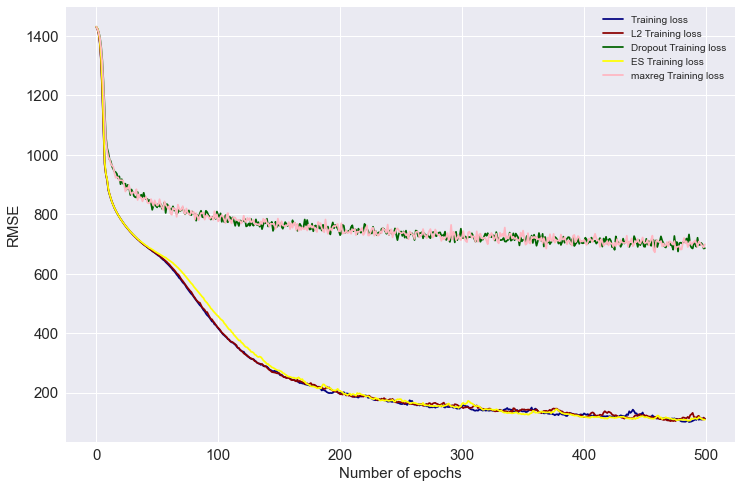

In [64]:
# looking at only train aacross different DL models and regularization 
plt.figure(figsize=(12, 8))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Number of epochs',fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.plot(train_loss, label='Training loss', color='navy')

plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')

plt.plot(train_loss_dropout, label='Dropout Training loss', color='darkgreen')

plt.plot(train_loss_es, label='ES Training loss', color='yellow')

plt.plot(train_loss_maxreg, label='maxreg Training loss',color='lightpink')

plt.legend();

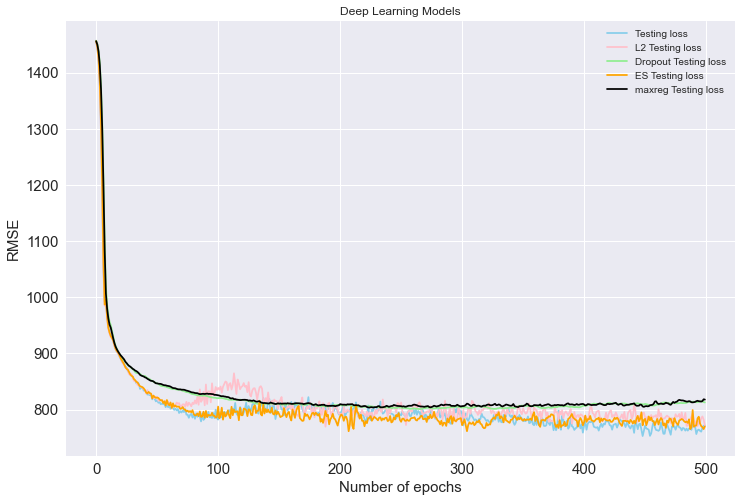

In [65]:
# looking at only test dataset across all DL models
plt.figure(figsize=(12, 8))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Number of epochs',fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.title('Deep Learning Models')


plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')

plt.plot(test_loss_dropout, label='Dropout Testing loss', color='lightgreen')

plt.plot(test_loss_es, label='ES Testing loss', color='orange')

plt.plot(test_loss_maxreg,label='maxreg Testing loss',color='black')
plt.legend();

# Evaluation Overview - Random Forest
- Based on the evaluation metric of RMSE, the random forest model has the lowest scoring, a RMSE of 658, i.e. the prediction error is the lowest amongst the rest, even when compared to deep learning models. 
- deep learning models RMSE score are in the range of 750 to 850 


In [66]:
results

,Ticker,Actual,lrpred,lr_ridge_pred,lr_lasso_pred,lr_elastic_pred,lr_PCA_pred,rf_pred,dl_pred,dl_ridge_pred,dl_dropout_pred,dl_earlystop_pred,dl_maxreg_pred
1702,BME,494.52,1223.09,1140.00,1241.15,1079.46,996.93,1479.32,155.73,1124.329956,1109.609985,896.630005,1258.349976
1173,NYCB,3804.13,3115.94,2645.69,3074.79,2257.66,1731.29,2864.12,31.73,2810.159912,3659.669922,2879.909912,3845.879883
308,WTS,3395.62,1945.09,1925.33,1837.17,1801.42,1977.53,2720.14,1284.18,2506.340088,2197.040039,2221.070068,2332.729980
1322,MTLS,1940.69,1709.09,1547.72,1448.15,1478.48,1695.81,862.32,301.98,759.030029,1283.589966,840.419983,1378.989990
2570,NEOS,27.66,147.94,195.02,168.69,349.37,896.65,129.45,1284.18,268.420013,124.000000,66.709999,151.649994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,SGH,690.80,1417.94,1387.11,1228.37,1357.39,1448.36,595.06,1284.18,764.460022,1085.699951,617.179993,1184.319946
443,DXLG,15.09,-112.06,279.39,380.37,383.06,311.51,129.45,1284.18,10.810000,175.720001,39.410000,172.300003
1483,RNA,1084.81,1115.09,1097.31,1221.80,1047.68,920.46,1242.11,1284.18,1146.439941,753.409973,1087.209961,809.010010
668,PAVM,86.93,51.94,-56.71,-47.56,5.02,-170.77,129.45,1284.18,-0.270000,77.059998,36.799999,78.440002


In [67]:
coefficientsx

,lr_cf,lr_ridge_cf,lr_lasso_cf,lr_elastic_cf
P/E,2.627591e+01,25.327702,14.604229,21.239412
Forward P/E,7.653420e+01,63.095401,63.420490,54.720372
PEG,-5.806233e+00,-7.969645,-0.000000,-5.555167
P/S,8.299376e+00,5.253895,0.000000,3.938746
P/B,-2.621806e+00,-2.747203,-0.000000,-1.845695
...,...,...,...,...
Industry_Utilities - Renewable,2.751560e+15,16.598038,9.233198,14.329563
Industry_Waste Management,1.447900e+15,2.001962,0.000000,1.281315
goldencross_buy,-9.696411e+15,31.926217,0.000000,28.644739
goldencross_neutral,-2.287509e+15,24.200636,4.524902,17.010119


In [68]:
pd.DataFrame(metricj)

,lr,lr_ridge,lr_lasso,lr_elastic,PCA,rf
Mean Absolute Error,556.641055,546.327335,519.760771,566.762180,628.296429,380.335163
Mean Squared Error,645736.453271,635356.261119,587375.652367,673575.327393,841248.856139,433248.437532
Root MSE,803.577285,797.092379,766.404366,820.716350,917.196193,658.216102
R2 Adjusted,0.367885,0.378046,0.425015,0.340633,0.324997,0.575891
R2 Train Score,0.519840,0.525920,0.516382,0.497860,0.402952,0.817572
R2 Test Score,0.518318,0.526061,0.561852,0.497552,0.372477,0.676822


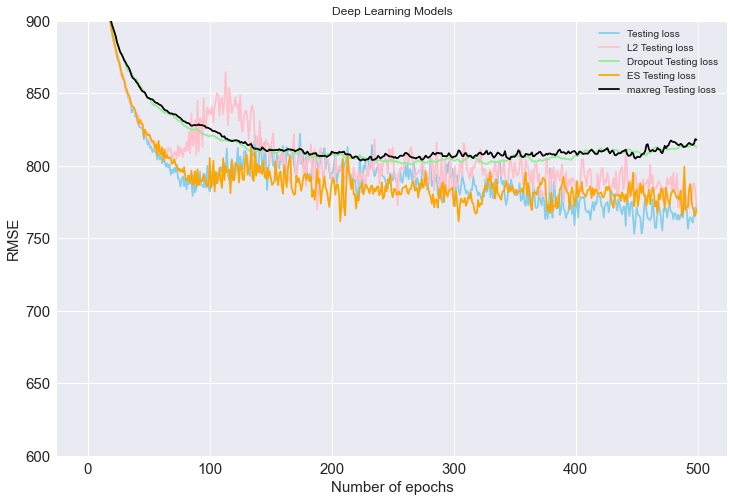

In [69]:
# looking at only test dataset across all DL models
plt.figure(figsize=(12, 8))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Number of epochs',fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.title('Deep Learning Models')
plt.ylim(600,900)

plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')

plt.plot(test_loss_dropout, label='Dropout Testing loss', color='lightgreen')

plt.plot(test_loss_es, label='ES Testing loss', color='orange')

plt.plot(test_loss_maxreg,label='maxreg Testing loss',color='black')
plt.legend();

##### Choosing 5 companies @ random for analysis

In [70]:
np.random.seed(42)
companies5 = np.random.choice(results['Ticker'],size=5)
companies5 

array(['WHD', 'CHEK', 'ICBK', 'LOGC', 'ABTX'], dtype=object)

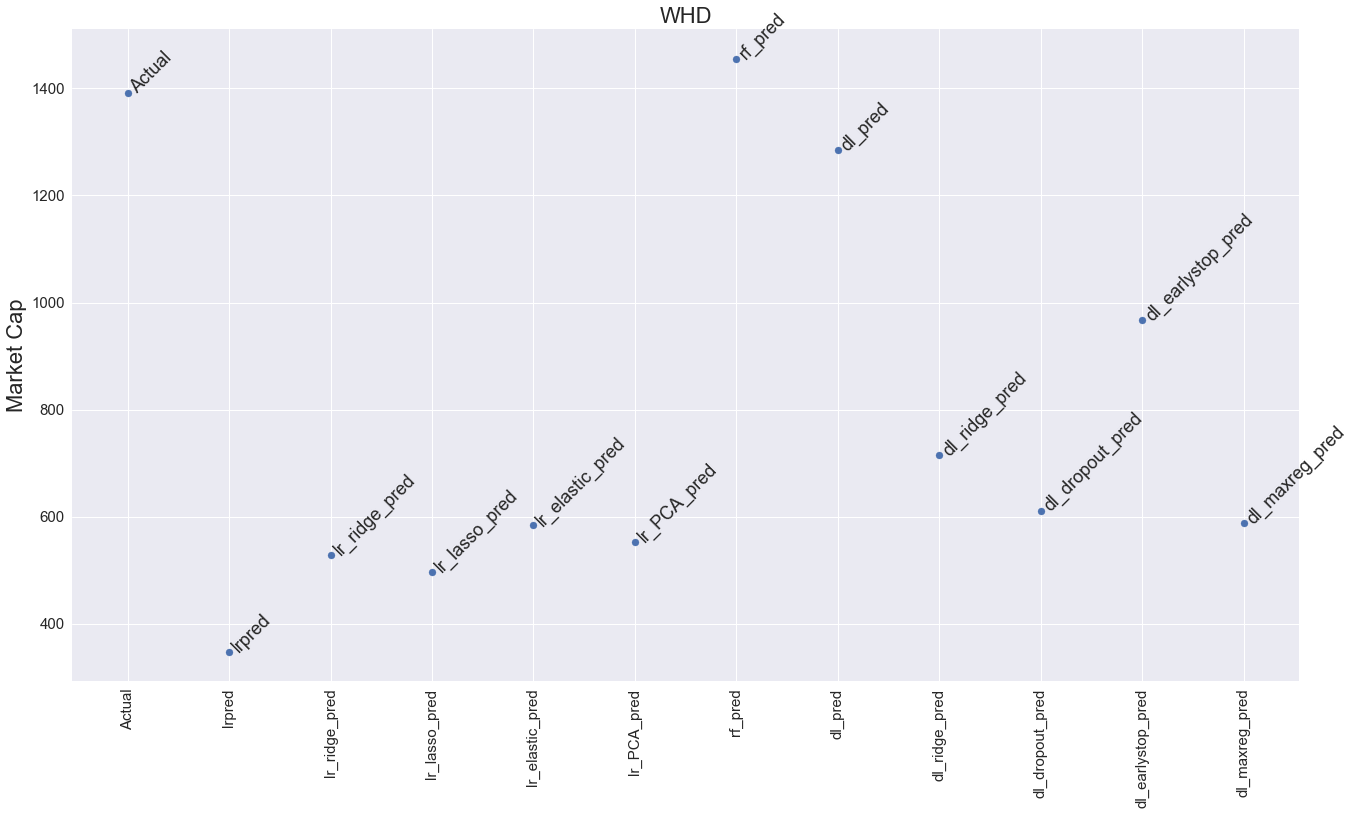

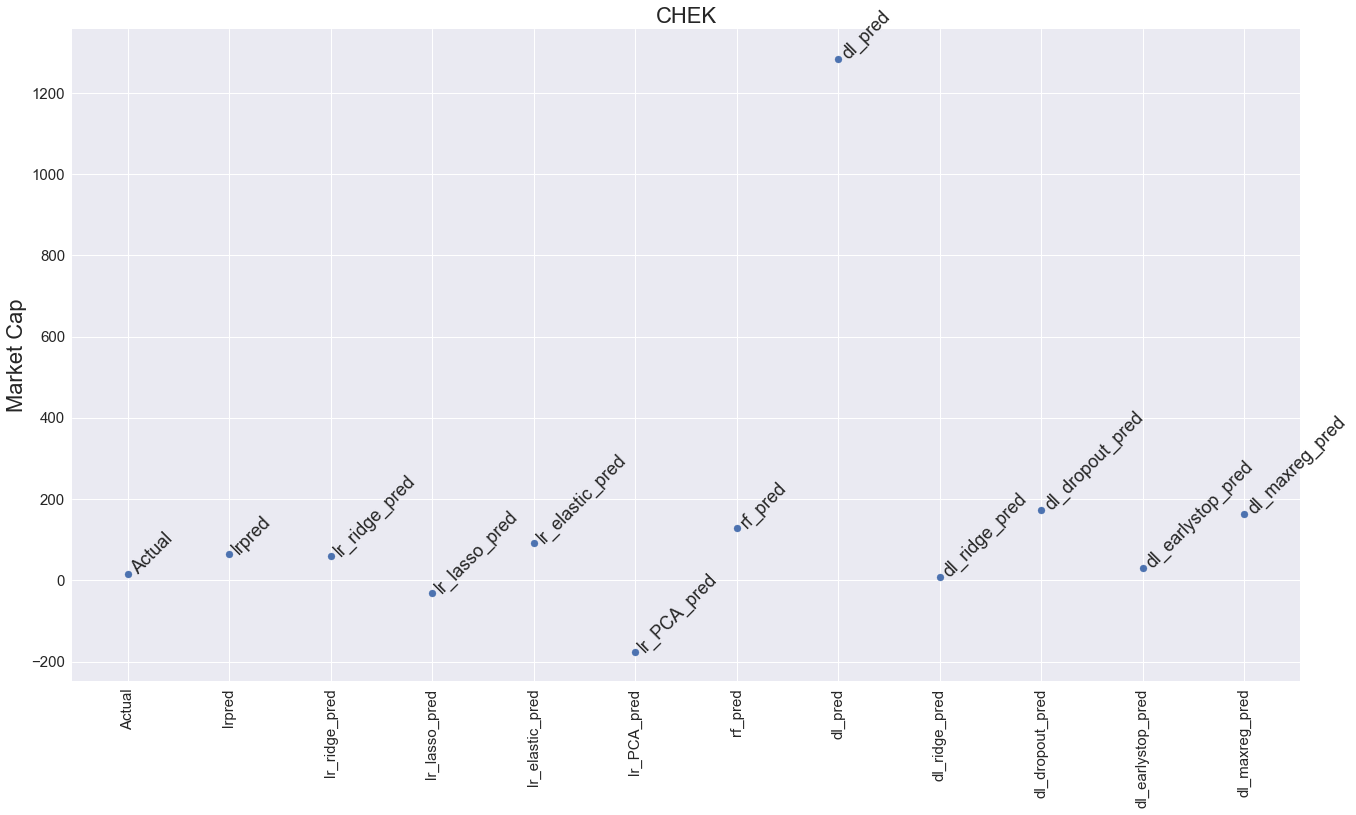

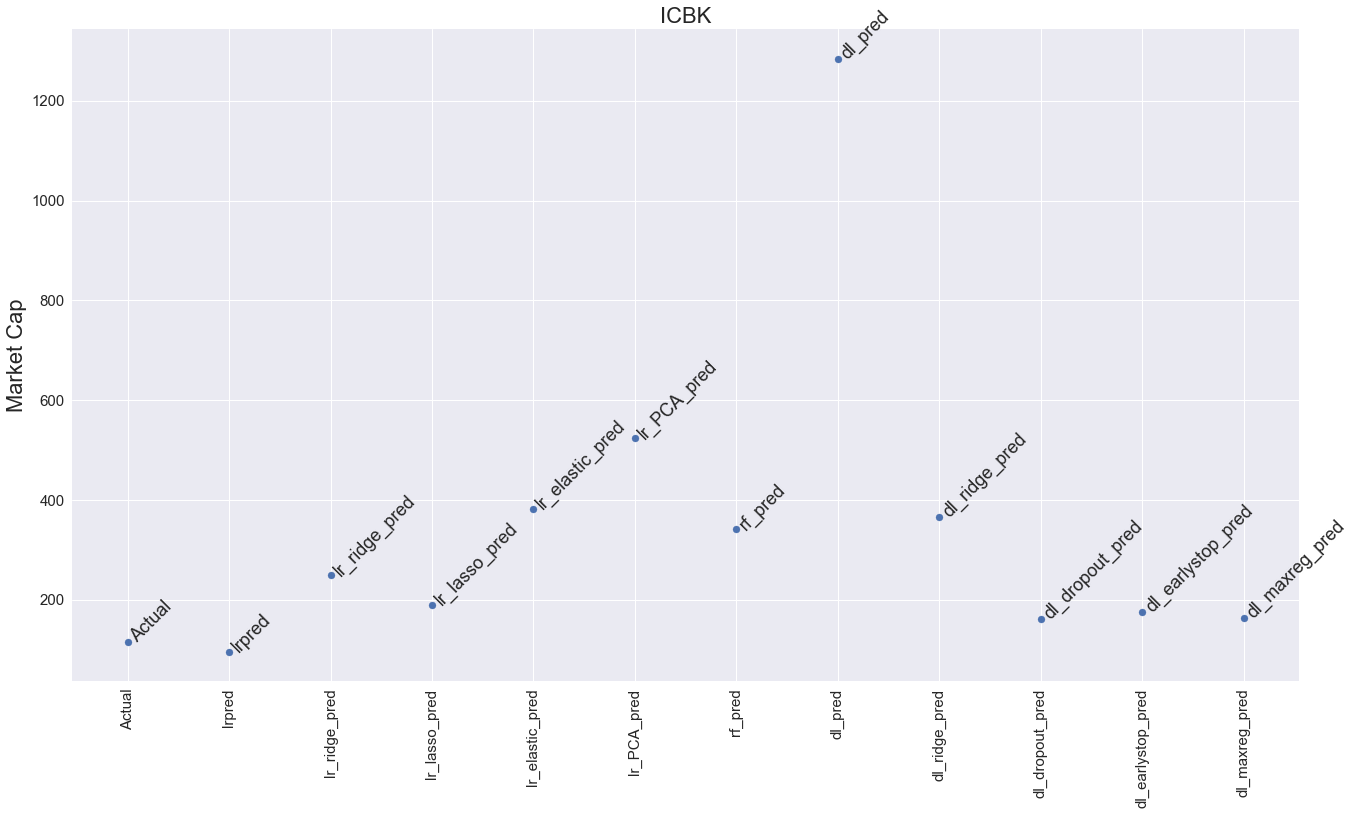

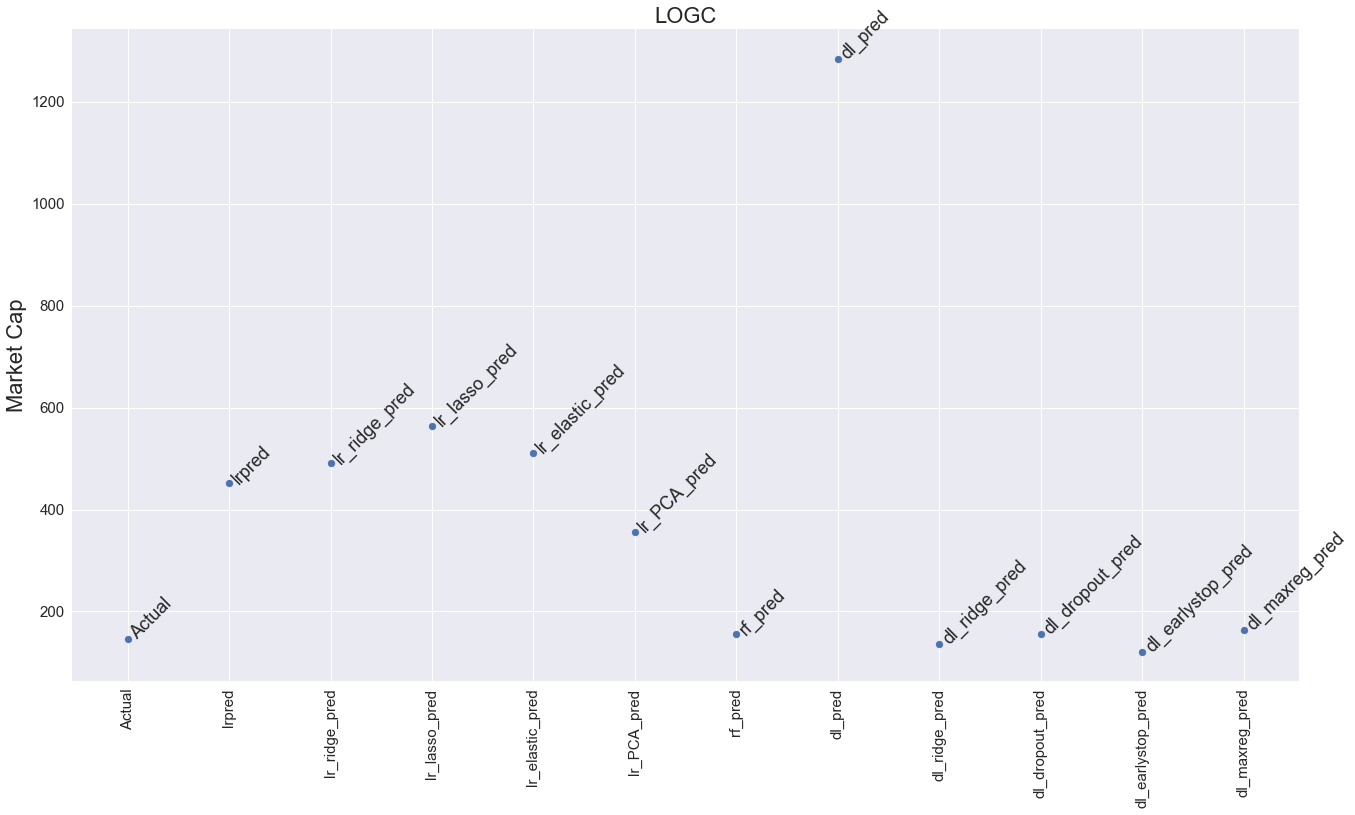

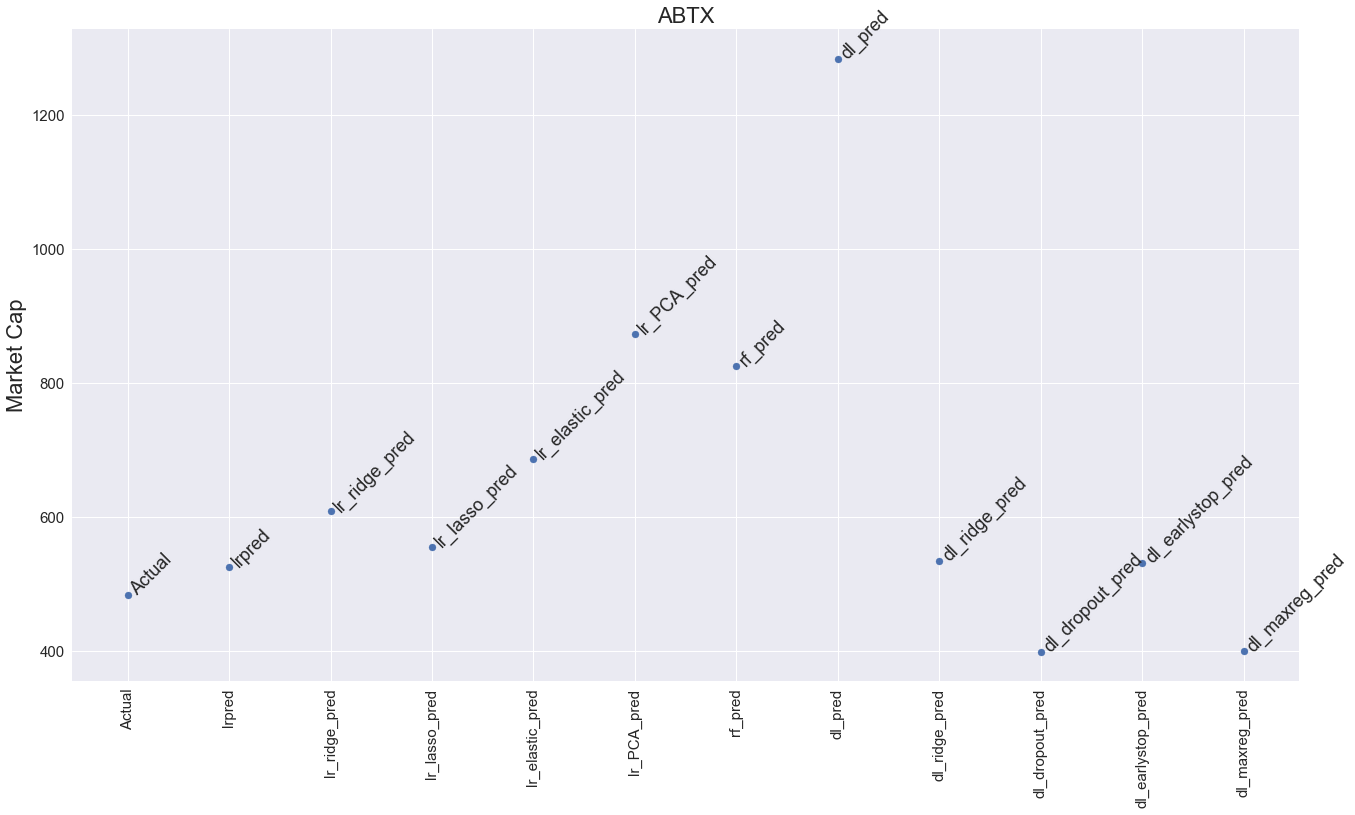

In [71]:
cmap = cm.get_cmap('Spectral')
n = list(results.columns[1:])
z = results.columns[1:]

for companies in companies5:
    y = results.loc[results['Ticker'] == companies][results.columns[1:]].T.values
    plt.figure(figsize=(22, 12))
    plt.title(companies,fontsize=22)
    plt.xticks(fontsize = 15,rotation=90)
    plt.yticks(fontsize = 15)
    plt.ylabel('Market Cap',fontsize=22)
    plt.scatter(x=results.columns[1:],y=y)

    for i, txt in enumerate(n):
        plt.annotate(txt, (z[i], y[i]),rotation=45,fontsize=18)
        

    plt.show()
    

# 5 stock analysis 

###  WHD - Cactus Inc 

- Next Earnings Date : 28 Oct 2020 
- 01 Oct 2020 Market Cap = US\$1.39 Billion
- 14 Oct 2020 Market Cap = US\$1.51 Billion
- Predicted Value = US\$1.46 Billion

- Sector: Energy , Industry : Oil and Gas Equipment Services
- Insti ownership : 50.7%
- EPS: 1.29
- Gross Margin : 34.9%
- Random Forest Predicts that WHD should increase valuation to $1.46 Billion
- Status: Random Forest prediction on track

![WHD](./images/WHD.jpg)




###  CHEK - Check-Cap Ltd. 

- Next Earnings Date : 09 Nov 2020 
- 01 Oct 2020 Market Cap = US\$15.76 Billion
- 14 Oct 2020 Market Cap = US\$17.53 Billion
- Predicted Value = US\$129.45 Billion

- Sector: Healthcare , Industry : Diagnostics & Research
- Insti ownership : 5.9%
- EPS: 0.11
- Gross Margin : 53%
- Random Forest Predicts that CHEK should increase valuation to $129.45 Billion
- Status: Random Forest prediction on track
![CHEK](./images/CHEK.jpg)


####  ICBK - County Bancorp Ltd. 

- Next Earnings Date : 22 Oct 2020 
- 01 Oct 2020 Market Cap = US\$116.4 Billion
- 14 Oct 2020 Market Cap = US\$119.63 Billion
- Predicted Value = US\$314.47 Billion

- Sector: Financial , Industry : Banks - Regional
- Insti ownership : 27.4%
- EPS: 0.90
- Gross Margin : 64%
- Random Forest Predicts that ICBK should increase valuation to US\$314.47 Billion
- Status: Random Forest prediction on track
![ICBK](./images/ICBK.jpg)


####  LOGC - LogicBio Therapeutics. 

- Next Earnings Date : 07 Dec 2020 
- 01 Oct 2020 Market Cap = US\$146.57 million
- 14 Oct 2020 Market Cap = US\$213.81 million
- Predicted Value = US\$155.23 Billion

- Sector: Healthcare , Industry : Biotechnology
- Insti ownership : 64%
- EPS: 1.89
- Gross Margin : 53%
- Random Forest Predicts that LOGC should increase valuation to US\$155.23 million
- Status: Random Forest prediction on track, super-exceeded
![LOGC](./images/LOGC.jpg)


####  ABTX - Allegiance Bancshares 

- Next Earnings Date : 29 Oct 2020 
- 01 Oct 2020 Market Cap = US\$484.54 Million
- 14 Oct 2020 Market Cap = US\$513.59 Million
- Predicted Value = US\$826.02 Million

- Sector: Financial , Industry : Banks Regional
- Insti ownership : 46.90%
- EPS: 1.88
- Gross Margin : 64%
- Random Forest Predicts that LOGC should increase valuation to US\$826.02 Million
- Status: Random Forest prediction on track
![ABTX](./images/ABTX.jpg)


# Conclusion

### Business Recommendation
- Important financial vitals
    - Investors should consider looking at Insitutional ownership, EPS and Gross margin as features, although Random Forest is unable to tell the coefficient weightage, however, based on EDA , it has shown that companies generally do well with higher values of these parameters, i.e. Market Cap grows , as these features increases in value.

- Predicted market cap benefits
    - Helps investors to know which stocks to buy 
        - Investors now are able to identify under-valued companies to invest, i.e. to say, given what my random forest predicted value, if the current market cap is lower than what the predicted value is, investors can buy those stocks.
    - Helps investors to know when to take profit if they holding the company
            - With the targeted market cap, investors will now be able to know when to take profit, for example if one is holding LOGC, and the stock market cap has surpassed its predicted value, investors should realise their profits before the next earnings season, because no one knows what the next earnings report will be like. As seen from EDA, if LOGC reports a negative gross margin, there is a high chance the market cap will decrease.
  

### Limitations

- Selecting 5 stocks at random
    - My test data has 854 companies, i only selected 5 stocks at random, hence it is too little to tell whether overall , the random forest fares good or bad. 
- Time expiration : Next Earnings Report
    - the model uses financial data that are based on the most recent quarterly earnings / financial statements, hence the stock has a timeline to reach to its target market valuation, which is a day before the next earnings date, because when the new earnings date is released, the financial data for most predictor will change. 
- Model for companies under US\$5 billion
    - the companies studied are below US\$5 billion, i.e. to say the model is suited only for companies below this market valuation. Companies with higher valuation but similiar financial vitals , would definitely be deemed higher over-valued. 

- Further exploration in Deep Learning Parameters
    - there can be further exploration in the parameters of deep learning, by increasing more layers and testing more regularisation parameters, a stronger model can be developed. 

